## Read data

In [1]:
data <- read.table("../data/scz_26Jan_2016.txt", header =TRUE)
missenseD <- read.table("../data/SCZ.missense.mut.countInGenes.sort.txt", header = FALSE)

data$dn_missense <- rep(0, dim(data)[1])
x1 <- pmatch(missenseD[, 1], data$Gene)
x11 <- cbind(missenseD, x1)
x11 <- x11[!is.na(x11[, 3]), ]
data[x11[, 3], ]$dn_missense <- x11[, 2]

missenseD <- read.table("../data/swexm_counts_MAFlt0p001.sort.missense.gene.counts.txt", header = TRUE)
missenseD <- read.table("../data/All.swexm.ex_and_noexac.txt.annotated.sort.missense.count_inGene", header = TRUE)
data$case_missense <- rep(0, dim(data)[1])
data$control_missense <- rep(0, dim(data)[1])

x1 <- pmatch(missenseD[, 1], data$Gene)
x11 <- cbind(missenseD, x1)
x11 <- x11[!is.na(x11[, 4]), ]
data[x11[, 4], ]$case_missense <- x11[, 3]
data[x11[, 4], ]$control_missense <- x11[, 2]


dim(data)
ntrio <- 617 #Menachem
ntrio <- ntrio + 14 #Girard
ntrio <- ntrio + 105 #Gulsuner
ntrio <- ntrio + 57 #McCarthy
ntrio <- ntrio + 231 #Xu

ncase = 4954
ncontrol <- 6239
N <- list(dn=ntrio, ca=ncase, cn= ncontrol)
#write.table(data, "../data/scz_data_2016_reannotateMissense.txt", row.names = FALSE, quote = FALSE)
data <- data[data$mut_lof > 0, ]
data <- data[data$mut_missense >0, ]
dim(data)

head(data, 3)


[1] 21376    13

[1] 18986    13

,Gene,mut_lof,mut_missense,dn_damaging,dn_lof,control_damaging,case_damaging,control_lof,case_lof,mut_damaging,dn_missense,case_missense,control_missense
1,A1BG,9.996657e-07,2.300224e-05,0,0,1,0,1,0,4.54062e-07,0,15,16
3,A1CF,2.144318e-06,1.68827e-05,0,0,5,2,1,2,3.35199e-06,0,25,23
4,A2M,3.981797e-06,4.039597e-05,0,0,8,5,13,6,7.82154e-06,0,37,62


## Test for single types of variants

In [2]:
denovoBinomSingle <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;

int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];
}
parameters {
real<lower=0.001,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
hyperGammaMeanLoFdn ~ normal(10, 100);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn);

increment_log_prob(log_sum_exp(ps));
}

}
"
yLoF <- data$dn_lof
y.case.lof <- data$case_lof
y.control.lof <- data$control_lof

yDamaging <- data$dn_damaging
y.case.Damaging <- data$case_damaging
y.control.Damaging <- data$control_damaging

yMis3 <- data$dn_missense
#y.case.mis3 <- data$case_damaging
#y.control.mis3 <- data$control_damaging

mutLoF <- data$mut_lof
mutDamaging <- data$mut_damaging
mutMis3 <- data$mut_missense

#yLoF = yMis3; mutLoF <- mutMis3
mixdataSingle <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      Ndn = N$dn, NN = length(yLoF))                 


### Test for only LoF

In [4]:
library("rstan")
nSeed <- 233
mLoF <- stan_model(model_code = denovoBinomSingle)
NSample <- 500000
nOutSample <- 5000
fLoF <- vb(mLoF, seed = nSeed, data = mixdataSingle, iter = 500000, output_sample = nOutSample)
fLoF

Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'


Warning message:
: passing unknown arguments: output_sample.


This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.007549 seconds
1000 iterations under these settings should take 7.549 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -8e+02             1.000            1.000
   200     -776.9             0.528            1.000
   300     -771.6             0.354            0.056
   400     -774.3             0.266            0.056
   500     -771.6             0.214            0.007   MEDIAN ELBO CONVERGED

Drawing 1000 samples from the approximate posteri

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: c9fb2b5894771eebfb67e990c7b805f0.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.18 0.04 0.11 0.15 0.18 0.20  0.25
hyperGammaMeanLoFdn 7.08 2.49 3.49 5.35 6.65 8.26 13.12
hyperBetaLoFdn      0.99 0.01 0.97 0.98 0.99 1.00  1.01
gammaLoFdn          7.08 1.16 5.24 6.26 6.97 7.74  9.64
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Sun Feb  7 21:58:50 2016.


SAMPLING FOR MODEL 'c9fb2b5894771eebfb67e990c7b805f0' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)# 
#  Elapsed Time: 183.132 seconds (Warm-up)
#                140.653 seconds (Sampling)
#                323.784 seconds (Total)
# 


The following numerical problems occured the indicated number of times after warmup on chain 1
                                                                                    count
Exception thrown at line 26: gamma_log: Shape parameter is inf, but must be finite!     1
When a numerical problem occurs, the Metropolis proposal gets rejected.
However, by design Metropolis proposals sometimes get rejected even when there are no numerical problems.
Thus, if the number in the 'count' column is small, do not ask about this message on stan-users.



SAMPLING FOR MODEL 'c9fb2b5894771eebfb67e990c7b805f0' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 2, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 2, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 2, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 2, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 2, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 2, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 2, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 2, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 2, Iteration: 2000 / 2000 [100%]  (Sampling)# 
#  Elapsed Time: 199.345 seconds (Warm-up)
#                174.705 seconds (Sampling)
#                374.05 seconds (Total)
# 


The following numerical problems occured the indicated number of times after warmup on chain 2
                                                                                                     count
Exception thrown at line 33: binomial_log: Probability parameter is 1.00868, but must be between (0,     1
Exception thrown at line 33: binomial_log: Probability parameter is 4.93887e+230, but must be betwee     1
When a numerical problem occurs, the Metropolis proposal gets rejected.
However, by design Metropolis proposals sometimes get rejected even when there are no numerical problems.
Thus, if the number in the 'count' column is small, do not ask about this message on stan-users.


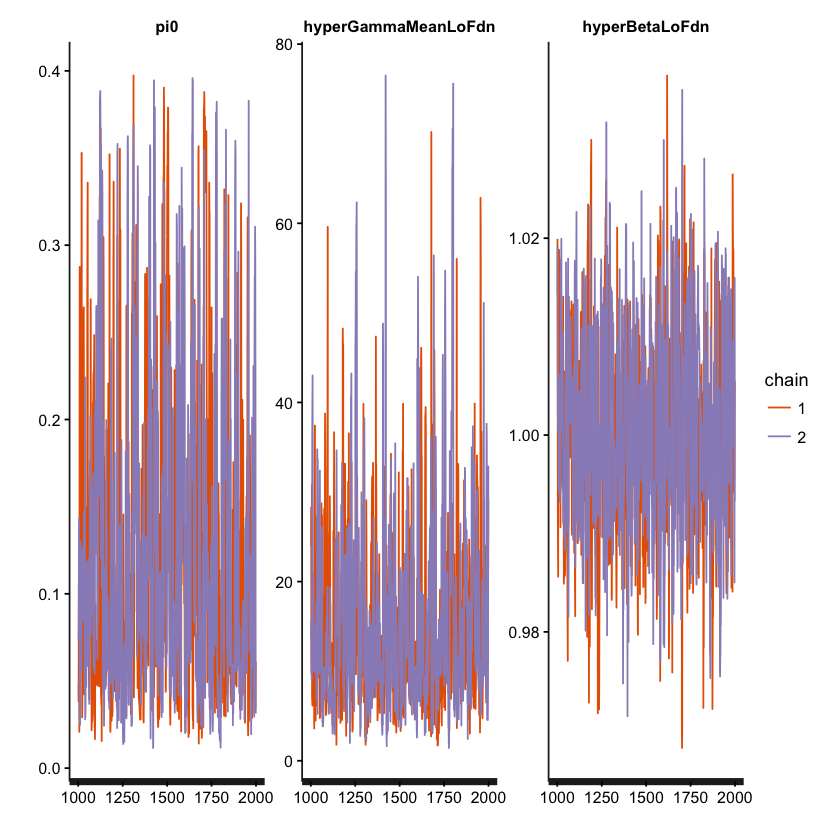

In [14]:
testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = 2000, chains = 2, 
                      control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn', 'hyperBetaLoFdn'))
stan_trace(testFitSingle)


In [15]:
testFitSingle

Inference for Stan model: c9fb2b5894771eebfb67e990c7b805f0.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                       mean se_mean    sd    2.5%     25%     50%     75%
pi0                    0.12    0.00  0.09    0.02    0.06    0.09    0.16
hyperGammaMeanLoFdn   15.28    0.51 10.18    3.39    7.89   12.96   20.05
hyperBetaLoFdn         1.00    0.00  0.01    0.98    0.99    1.00    1.01
lp__                -766.29    0.08  1.56 -770.11 -767.09 -765.95 -765.14
                      97.5% n_eff Rhat
pi0                    0.35   344    1
hyperGammaMeanLoFdn   39.89   401    1
hyperBetaLoFdn         1.02   780    1
lp__                -764.31   367    1

Samples were drawn using NUTS(diag_e) at Mon Feb  8 10:38:04 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

### Test for only damaging missense

In [5]:
yDamaging <- cbind(yDamaging, mutDamaging)
yDamaging <- yDamaging[yDamaging[, 2]> 0, ]
y1 <- yDamaging[, 1]
y2 <- yDamaging[, 2]
mixdataSingleDamaging <- list(K = 2, 
                          yLoFdn = y1, mutLoF = y2,
                          Ndn = N$dn, 
                          NN = length(y1))                 

nSeed1 <- 12345 #233
mDamaging <- stan_model(model_code = denovoBinomSingle)
NSample <- 500000
nOutSample <- 5000
fDamaging <- vb(mDamaging, seed = nSeed1, data = mixdataSingleDamaging,
            iter = NSample, output_samples= nOutSample)
fDamaging


This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.006 seconds
1000 iterations under these settings should take 5.846 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Iteration: 250 / 250 [100%]  (Adaptation)
Success! Found best value [eta = 0.100].

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -915.0             1.000            1.000
   200     -821.2             0.557            1.000
   300     -774.4             0.392            0.114
   400     -715.3             0.314            0.114
   500     -706.2             0.254            0.083
   600     -689.3             0.216            0.083


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: c9fb2b5894771eebfb67e990c7b805f0.
1 chains, each with iter=5000; warmup=0; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.19 0.11 0.01 0.09 0.18 0.29  0.38
hyperGammaMeanLoFdn 2.43 1.43 1.19 1.57 2.00 2.77  6.17
hyperBetaLoFdn      1.00 0.02 0.96 0.99 1.00 1.01  1.03
gammaLoFdn          1.01 0.32 0.64 0.79 0.93 1.13  1.85
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Sun Feb  7 21:59:10 2016.

## Test for only missense

In [6]:
yMis3A <- cbind(yMis3, mutMis3)
yMis3A <- yMis3A[yMis3A[, 2]> 0, ]
y1 <- yMis3A[, 1]
y2 <- yMis3A[, 2]
length(y2)
mixdataSingleMis3 <- list(K = 2, 
                          yLoFdn = y1, mutLoF = y2,
                          Ndn = N$dn, 
                          NN = length(y1))                 


nSeed1 <- 12345 #233
mMis3 <- stan_model(model_code = denovoBinomSingle)
NSample <- 500000
nOutSample <- 5000
fMis3 <- vb(mMis3, seed = nSeed1, data = mixdataSingleMis3,
            iter = NSample, output_samples= nOutSample)
fMis3


[1] 18986


This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.008 seconds
1000 iterations under these settings should take 7.645 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1.000] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100    -3220.5             1.000            1.000
   200    -3211.6             0.501            1.000
   300    -3214.1             0.335            0.003   MEDIAN ELBO CONVERGED

Drawing 5000 samples from the approximate posterior... COMPLETED.


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: c9fb2b5894771eebfb67e990c7b805f0.
1 chains, each with iter=5000; warmup=0; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.33 0.05 0.21 0.31 0.34 0.36  0.39
hyperGammaMeanLoFdn 2.04 1.08 1.13 1.40 1.72 2.28  4.84
hyperBetaLoFdn      0.97 0.01 0.95 0.97 0.97 0.98  1.00
gammaLoFdn          0.57 0.05 0.51 0.53 0.55 0.58  0.69
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Sun Feb  7 21:59:19 2016.

## Combine LoF case-control + denovo

In [7]:
denovoCCBinom <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];


real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
hyperGammaMeanLoFdn ~ normal(15, 10);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"


#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
mixdataDenovoCC <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        yLoFdn = yLoF, mutLoF = mutLoF,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))



In [8]:
NSample <- 500000
mBothDenovoCC <- stan_model(model_code = denovoCCBinom)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC <- vb(mBothDenovoCC, seed = nSeed1,
                    data = mixdataDenovoCC,
                    iter = NSample, output_samples= 1000)
fBothDenovoCC


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.020718 seconds
1000 iterations under these settings should take 20.718 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Iteration: 250 / 250 [100%]  (Adaptation)
Success! Found best value [eta = 0.1].

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -9e+04             1.000            1.000
   200   -82758.6             0.568            1.000
   300   -86242.6             0.392            0.136
   400   -5749

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.19 0.04 0.12 0.17 0.19 0.22  0.27
hyperGammaMeanLoFcc 1.62 0.57 1.11 1.27 1.45 1.75  3.02
hyperBetaLoFcc      4.00 0.05 3.91 3.97 4.00 4.03  4.10
gammaLoFcc          1.00 0.04 0.93 0.97 1.00 1.02  1.08
hyperGammaMeanLoFdn 7.24 3.30 3.35 4.95 6.49 8.67 15.41
hyperBetaLoFdn      1.00 0.01 0.98 1.00 1.00 1.01  1.02
gammaLoFdn          6.26 1.06 4.54 5.47 6.19 6.92  8.53
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Sun Feb  7 22:06:15 2016.

## Results for LoF de novo + case-control

In [12]:
testFitDenovoCC <- stan(model_code = denovoCCBinom,
                        data = mixdataDenovoCC, iter = 5000, chains = 2, cores = 2, 
                        control = list(adapt_delta = 0.9),
                        pars = c('pi0',
                                 'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                 'hyperBetaLoFdn', 'hyperBetaLoFcc'))


In [16]:
testFitDenovoCC

Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
2 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=5000.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.04    0.00 0.01      0.02      0.03      0.03
hyperGammaMeanLoFdn     24.57    0.17 6.55     12.51     19.93     24.29
hyperGammaMeanLoFcc      2.24    0.02 0.75      1.12      1.68      2.14
hyperBetaLoFdn           1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -19050.45    0.06 2.02 -19055.14 -19051.65 -19050.14
                          75%     97.5% n_eff Rhat
pi0                      0.04      0.07  1290    1
hyperGammaMeanLoFdn     28.85     37.95  1524    1
hyperGammaMeanLoFcc      2.68      3.98  1896    1
hyperBetaLoFdn           1.01      1.02  2678    1
hyperBetaLoFcc           4.01      4.02  3381    1
lp__ 

## Both LoF + missense

In [9]:
######LOF + Missense
denovoCCBinom21 <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];

int<lower=0> yCaseMis3[NN];
int<lower=0> yTotalMis3[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];

real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.95> pi0;

real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=1> hyperGammaMeanMis3cc;
real<lower=0.5> hyperBetaMis3cc;
real<lower=0.5> gammaMis3cc;
real<lower=1> hyperGammaMeanMis3dn;
real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;

}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
//pi0 ~ normal(0.03, 0.02); //uniform(0, 0.15);
hyperGammaMeanLoFdn ~ uniform(2, 50); //normal(15, 10);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);

////
hyperGammaMeanMis3dn ~ normal(15, 10);
hyperBetaMis3dn ~ normal(1, 0.01);
gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);

hyperGammaMeanMis3cc ~ normal(15, 10);
hyperBetaMis3cc ~ normal(4, 0.01);
gammaMis3cc ~ gamma(hyperGammaMeanMis3cc*hyperBetaMis3cc, hyperBetaMis3cc);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0)
+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]*gammaMis3dn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol))
+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"

y.case.lof <- data$case_lof
y.control.lof <- data$control_lof
yLoF <- data$dn_lof
mutLoF <- data$mut_lof

y.case.mis3 <- data$case_missense
y.control.mis3 <- data$control_missense
yMis3 <- data$dn_missense
mutMis3 <- data$mut_missense

mixdataDenovoCC2 <- list(K = 2, 
                      yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        
                        yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                        
                        yLoFdn = yLoF, mutLoF = mutLoF,
                        yMis3dn = yMis3, mutMis3 = mutMis3,
                        
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))


In [10]:
NSample <- 1000000
mBothDenovoCC2b <- stan_model(model_code = denovoCCBinom21)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC2b <- vb(mBothDenovoCC2b, seed = nSeed1,
                    data = mixdataDenovoCC2,
                    iter = NSample, output_samples= 10000)
fBothDenovoCC2b


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.043836 seconds
1000 iterations under these settings should take 43.836 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -1e+05             1.000            1.000
   200   -70791.1             0.865            1.000
   300   -70499.7             0.578            0.730
   400   -70480.3             0.434 

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 24f3c87ce1a324d20030d18f2d2803bd.
1 chains, each with iter=10000; warmup=0; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

                     mean   sd 2.5%  25%  50%  75% 97.5%
pi0                  0.24 0.02 0.20 0.23 0.24 0.26  0.29
hyperGammaMeanLoFcc  1.83 1.02 1.07 1.26 1.51 1.98  4.59
hyperBetaLoFcc       4.04 0.01 4.03 4.04 4.04 4.05  4.06
gammaLoFcc           1.04 0.03 0.97 1.01 1.04 1.06  1.11
hyperGammaMeanLoFdn  6.63 3.18 2.69 4.43 5.93 8.04 14.61
hyperBetaLoFdn       0.96 0.01 0.94 0.95 0.96 0.97  0.98
gammaLoFdn           4.62 0.78 3.30 4.05 4.54 5.09  6.32
hyperGammaMeanMis3cc 1.43 0.43 1.06 1.17 1.29 1.53  2.53
hyperBetaMis3cc      3.96 0.02 3.92 3.95 3.96 3.98  4.00
gammaMis3cc          0.88 0.01 0.87 0.88 0.88 0.89  0.90
hyperGammaMeanMis3dn 2.00 1.14 1.11 1.36 1.65 2.20  5.05
hyperBetaMis3dn      0.98 0.01 0.96 0.98 0.98 0.99  1.00
gammaMis3dn          0.61 0.09 0.52 0.55 0.59 0.64  0.84
lp__                 0.0

In [17]:
testFitDenovoCC2 <- stan(model_code = denovoCCBinom21,
                        data = mixdataDenovoCC2, iter = 5000, chains = 2, cores = 2,
                        control = list(adapt_delta = 0.9),
                        pars = c('pi0',
                                 'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                 'hyperGammaMeanMis3dn', 'hyperGammaMeanMis3cc',
                                 'hyperBetaLoFdn', 'hyperBetaLoFcc'))


Warning message:
: There were 174 divergent transitions after warmup. Increasing adapt_delta above 0.9 may help.Warning message:
: Examine the pairs() plot to diagnose sampling problems


In [18]:
testFitDenovoCC2

Inference for Stan model: 24f3c87ce1a324d20030d18f2d2803bd.
2 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=5000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.29    0.00 0.06      0.19      0.24      0.28
hyperGammaMeanLoFdn       5.73    0.05 2.22      2.38      4.05      5.45
hyperGammaMeanLoFcc       1.52    0.01 0.40      1.02      1.21      1.45
hyperGammaMeanMis3dn      1.99    0.01 0.80      1.04      1.39      1.82
hyperGammaMeanMis3cc      1.48    0.01 0.37      1.02      1.19      1.40
hyperBetaLoFdn            1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc            4.00    0.00 0.01      3.98      3.99      4.00
lp__                 -70406.03    0.07 2.77 -70412.51 -70407.57 -70405.66
                           75%     97.5% n_eff Rhat
pi0                       0.32      0.44  1218    1
hyperGammaMeanLoFdn       7.07     10.87  2432    1


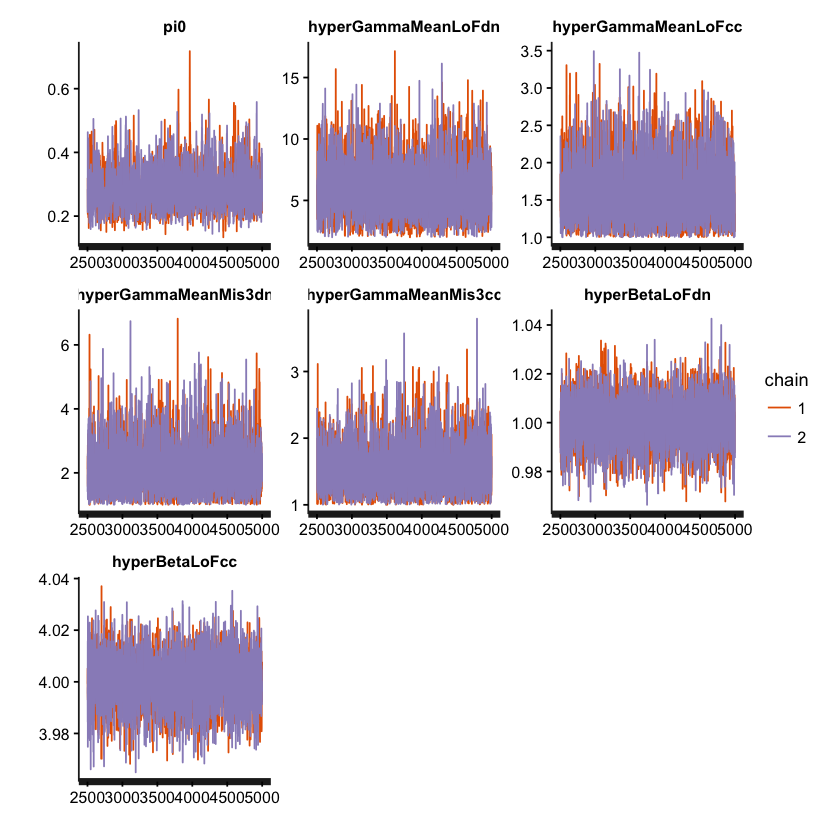

In [19]:
stan_trace(testFitDenovoCC2)

### Test Bayes Factor

In [22]:

y.case.lof <- data$case_lof
y.control.lof <- data$control_lof
yLoF <- data$dn_lof
mutLoF <- data$mut_lof

y.case.mis3 <- data$case_missense
y.control.mis3 <- data$control_missense
yMis3 <- data$dn_missense
mutMis3 <- data$mut_missense


bfcc <- function(ycase, ytotal, Ncase, Ncontrol,
                 lower.gamma = 1, upper.gamma = 50,
                 hyperGammaMeanCC = 1.94, hyperBetaCC = 1.98, tolERR = 10^-6){
  bfH0 <- dbinom(ycase, ytotal, prob = pH0)
  
  
  bfH1 <- apply(cbind(ycase, ytotal), 1, function(x){
    f1 <- function(gamma0)
      dbinom(x[1], x[2], gamma0*Ncase/(gamma0*Ncase + Ncontrol))*dgamma(gamma0, 
                                                                        shape = hyperGammaMeanCC*hyperBetaCC,
                                                                        rate = hyperBetaCC)
#    print(x)
    return(integrate(f1, lower = lower.gamma, upper = upper.gamma, rel.tol = tolERR)$value)
  })
  return(bfH1/bfH0)
  
}

                
Ncase <- N$ca
Ncontrol <- N$cn
pH0 <- Ncase/(Ncase + Ncontrol)

BFccLoF <- bfcc(ycase = y.case.lof, ytotal = y.case.lof + y.control.lof, Ncase = N$ca, Ncontrol = N$cn,
             hyperGammaMeanCC = 1.69, hyperBetaCC = 4.01)

range(BFccLoF)
yTemp <- y.case.mis3 + y.control.mis3

BFccMis3 <- bfcc(ycase = y.case.mis3, ytotal = y.case.mis3 + y.control.mis3, Ncase = N$ca, Ncontrol = N$cn,
                hyperGammaMeanCC = 1.46, hyperBetaCC = 4.05)
range(BFccMis3)

source("TADA/TADA.R")

BFdnLoF <- bayes.factor.denovo(x = yLoF, N = N$dn, mu = mutLoF, gamma.mean = 6.63, beta = 1)
BFdnMis3 <- bayes.factor.denovo(x = yMis3, N = N$dn, mu = mutMis3, gamma.mean = 2.08, beta = 1)

BFall <- BFccMis3*BFccLoF*BFdnLoF*BFdnMis3



data$BF <- BFall
data <- data[order(-data$BF),]
pi0 <- 1 - 0.24
data$qvalue <- Bayesian.FDR(data$BF, pi0)$FDR

data1 <- (data[data$qvalue < 0.1, ])
dim(data1)
head(data1, 25)


[1]  0.05718466 86.54227712

[1] 1.448734e-02 1.194035e+03

[1] 45 15

,Gene,mut_lof,mut_missense,dn_damaging,dn_lof,control_damaging,case_damaging,control_lof,case_lof,mut_damaging,dn_missense,case_missense,control_missense,qvalue,BF
17190,SLC6A17,1.323238e-06,2.58445e-05,0,0,4,6,0,0,6.73761e-06,1,49,22,0.001653001,1912.541
5774,FAM170B,4.906808e-07,1.062519e-05,0,0,0,0,0,0,3.27898e-07,0,15,0,0.01806108,88.70289
20253,WASF3,1.051618e-06,1.790442e-05,0,0,2,3,1,1,4.47245e-06,0,42,22,0.02434513,82.6201
1558,BECN1,1.355947e-06,1.330464e-05,0,0,1,11,0,0,3.97686e-06,0,20,4,0.02763336,81.28214
20344,WDR87,5.613641e-06,7.281103e-05,0,0,0,0,0,0,2.86618e-06,0,15,0,0.03026995,74.41672
19518,TSPAN32,1.040969e-06,1.169841e-05,0,0,1,0,4,5,1.2992e-07,0,42,23,0.03267423,67.6829
12320,NCOA2,3.197271e-06,4.063912e-05,0,0,4,10,1,0,7.85164e-06,0,69,46,0.03502246,61.31199
21307,ZNF93,8.189286e-07,1.412243e-05,0,0,0,0,10,2,0,0,43,20,0.03727674,56.51793
20328,WDR7,4.231627e-06,4.359147e-05,0,0,2,6,0,0,6.83811e-06,0,63,42,0.03971824,50.27895
21255,ZNF793,1.093721e-06,1.138094e-05,0,0,0,0,1,2,1.9573e-08,0,24,9,0.04228823,45.23992


### Set beta values as constants

In [23]:
#############Denovo + Case control: set betas as constants
denovoCCBinom22 <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];

int<lower=0> yCaseMis3[NN];
int<lower=0> yTotalMis3[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];

real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.95> pi0;

real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=1> hyperGammaMeanMis3cc;
real<lower=0.5> gammaMis3cc;
real<lower=1> hyperGammaMeanMis3dn;
real<lower=0.5> gammaMis3dn;

}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
//pi0 ~ normal(0.03, 0.02); //uniform(0, 0.15);
hyperGammaMeanLoFdn ~ uniform(2, 50); //normal(15, 10);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn, 1);

hyperGammaMeanLoFcc ~ normal(15, 10);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*4, 4);

////
hyperGammaMeanMis3dn ~ normal(15, 10);
gammaMis3dn ~ gamma(hyperGammaMeanMis3dn, 1);

hyperGammaMeanMis3cc ~ normal(15, 10);
gammaMis3cc ~ gamma(hyperGammaMeanMis3cc*4, 4);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0)
+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]*gammaMis3dn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol))
+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"



In [24]:
y.case.lof <- data$case_lof
y.control.lof <- data$control_lof
yLoF <- data$dn_lof
mutLoF <- data$mut_lof

y.case.mis3 <- data$case_missense
y.control.mis3 <- data$control_missense
yMis3 <- data$dn_missense
mutMis3 <- data$mut_missense

mixdataDenovoCC2b <- list(K = 2, 
                         yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                         
                         yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                         
                         yLoFdn = yLoF, mutLoF = mutLoF,
                         yMis3dn = yMis3, mutMis3 = mutMis3,
                         
                         NN = length(y.case.lof),
                         Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                         Ndn = N$dn,
                         thetaH0 = N$ca/(N$ca + N$cn))


In [25]:
NSample <- 1000000
mBothDenovoCC2bb <- stan_model(model_code = denovoCCBinom22)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC2bb <- vb(mBothDenovoCC2bb, seed = nSeed1,
                      data = mixdataDenovoCC2,
                      iter = NSample, output_samples= 10000,
                      grad_samples = 1)
fBothDenovoCC2bb


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.044574 seconds
1000 iterations under these settings should take 44.574 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -7e+04             1.000            1.000
   200   -70427.1             0.500            1.000
   300   -70420.5             0.333            0.000   MEDIAN ELBO CONVERGED

Drawing 100

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: acc6eb638346d37efe026f9fc6406bd5.
1 chains, each with iter=10000; warmup=0; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

                     mean   sd 2.5%  25%  50%  75% 97.5%
pi0                  0.22 0.02 0.19 0.21 0.22 0.23  0.26
hyperGammaMeanLoFcc  1.49 0.44 1.08 1.22 1.37 1.61  2.60
gammaLoFcc           1.00 0.04 0.92 0.97 1.00 1.03  1.09
hyperGammaMeanLoFdn  5.48 1.95 2.82 4.10 5.11 6.43 10.31
gammaLoFdn           5.53 0.75 4.21 5.00 5.48 6.00  7.15
hyperGammaMeanMis3cc 1.48 0.43 1.08 1.21 1.35 1.60  2.62
gammaMis3cc          0.90 0.01 0.89 0.90 0.90 0.90  0.91
hyperGammaMeanMis3dn 2.21 1.36 1.14 1.43 1.79 2.47  5.74
gammaMis3dn          0.59 0.06 0.52 0.55 0.58 0.62  0.75
lp__                 0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Mon Feb  8 16:13:48 2016.

In [26]:
testFitDenovoCC2bb <- stan(model_code = denovoCCBinom22,
                         data = mixdataDenovoCC2b, iter = 1000, chains = 2, 
                         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperGammaMeanMis3dn', 'hyperGammaMeanMis3cc'))


SAMPLING FOR MODEL 'acc6eb638346d37efe026f9fc6406bd5' NOW (CHAIN 1).

Chain 1, Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1, Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1, Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1, Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1, Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1, Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1, Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1, Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1, Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1, Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1, Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1, Iteration: 1000 / 1000 [100%]  (Sampling)# 
#  Elapsed Time: 972.943 seconds (Warm-up)
#                365.316 seconds (Sampling)
#                1338.26 seconds (Total)
# 


The following numerical problems occured the indicated number of times after warmup on chain 1
                                                                                                     count
Exception thrown at line 65: binomial_log: Probability parameter is nan, but must be finite!             2
Exception thrown at line 65: binomial_log: Probability parameter is 2.72207e+262, but must be betwee     1
When a numerical problem occurs, the Metropolis proposal gets rejected.
However, by design Metropolis proposals sometimes get rejected even when there are no numerical problems.
Thus, if the number in the 'count' column is small, do not ask about this message on stan-users.



SAMPLING FOR MODEL 'acc6eb638346d37efe026f9fc6406bd5' NOW (CHAIN 2).

Chain 2, Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 2, Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 2, Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 2, Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 2, Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 2, Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 2, Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 2, Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 2, Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 2, Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 2, Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 2, Iteration: 1000 / 1000 [100%]  (Sampling)# 
#  Elapsed Time: 1143.73 seconds (Warm-up)
#                392.179 seconds (Sampling)
#                1535.91 seconds (Total)
# 


The following numerical problems occured the indicated number of times after warmup on chain 2
                                                                                                     count
Exception thrown at line 65: binomial_log: Probability parameter is 2.24562, but must be between (0,     1
Exception thrown at line 65: binomial_log: Probability parameter is 2.97089e+193, but must be betwee     1
When a numerical problem occurs, the Metropolis proposal gets rejected.
However, by design Metropolis proposals sometimes get rejected even when there are no numerical problems.
Thus, if the number in the 'count' column is small, do not ask about this message on stan-users.


In [27]:
testFitDenovoCC2bb

Inference for Stan model: acc6eb638346d37efe026f9fc6406bd5.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.28    0.00 0.06      0.19      0.24      0.27
hyperGammaMeanLoFdn       5.79    0.10 2.23      2.54      4.13      5.51
hyperGammaMeanLoFcc       1.54    0.01 0.39      1.04      1.24      1.46
hyperGammaMeanMis3dn      2.01    0.04 0.85      1.02      1.35      1.80
hyperGammaMeanMis3cc      1.49    0.01 0.38      1.03      1.20      1.40
lp__                 -70405.15    0.13 2.30 -70410.42 -70406.52 -70404.91
                           75%     97.5% n_eff Rhat
pi0                       0.31      0.42   281 1.00
hyperGammaMeanLoFdn       7.03     10.87   522 1.01
hyperGammaMeanLoFcc       1.76      2.47   748 1.00
hyperGammaMeanMis3dn      2.42      4.12   465 1.00
hyperGammaMeanMis3cc      1.69      2.43   766

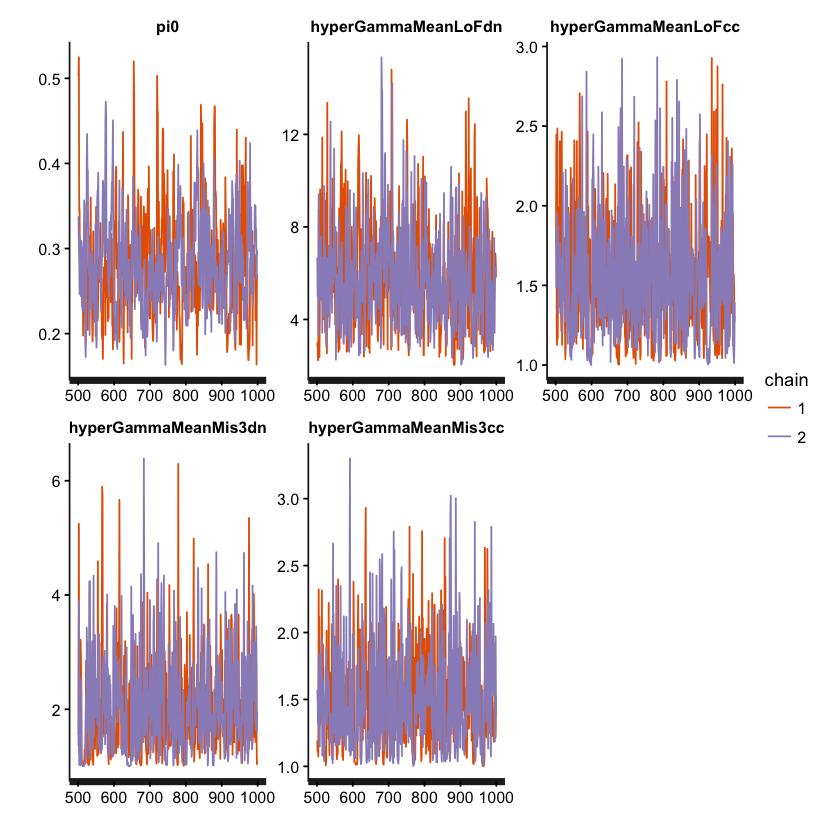

In [31]:

stan_trace(testFitDenovoCC2bb)